# Building a wineRatingPredictor
## Part 3: Train, Evaluate & Interpret Final Model
## 20 May 2020
## About RIHAD VARIAWA
> As a Data Scientist and former head of global fintech research at Malastare.ai, I find fulfillment tacking challenges to solve complex problems using data


![](https://media.giphy.com/media/3ohhwpzf1EmlkTUsO4/giphy.gif)

ML workflow to building a **wineRantingPredictor**:

1. Data Preprocessing
2. EDA
3. Feature Engineering & Feature Selection
4. Set Evaluation Metric & Establish Baseline
5. Selecting Models based on Evaluation Metric
6. Perform Hyperparameter Tuning on Selected Model
7. Train & Evaluate the Model
8. Interpret Model Predictions
9. Draw Conclusions

## This notebook covers steps 7 to 9

In [ ]:
!pip install lime

In [ ]:
# visualization and manipulation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 60)

%matplotlib inline
# to display visuals in the notebook

%config InlineBackend.figure_format='retina'
# to enable high resolution plots

# feature prepocessing and split
from sklearn.metrics import mean_squared_error

# machine Learning Models
from sklearn.ensemble import RandomForestRegressor

# to load machine learning model
import pickle

# to visualize a decision tree
import sklearn.tree as tree
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image

# LIME to explain predictions
import lime 
import lime.lime_tabular

# to bypass warnings in section regarding previous imports
import warnings
warnings.filterwarnings('ignore')

In [ ]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')

X_valid = pd.read_csv('X_valid.csv')
y_valid = pd.read_csv('y_valid.csv')

test_features = pd.read_csv('test_features.csv')
test_target = pd.read_csv('test_target.csv')

In [ ]:
# functions to use in the notebook
def fit_evaluate_model(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    return mean_squared_error(y_valid, y_predicted)

def convert_features_to_array(features):
    num_rows = len(features)
    num_cols = len(features.columns)
    
    features_array = (np
                      .array(features)
                      .reshape((num_rows, 
                                num_cols)))

    return features_array

def convert_target_to_array(target):
    target_array = np.array(target).reshape((-1, ))
    return target_array

In [ ]:
# convert to train, valid, test sets to array
X_train_array = convert_features_to_array(X_train)
y_train_array = convert_target_to_array(y_train)

X_valid_array = convert_features_to_array(X_valid)
y_valid_array = convert_target_to_array(y_valid)

X_test_array = convert_features_to_array(test_features)
y_test_array = convert_target_to_array(test_target)

In [ ]:
# convert merged train and target sets to array
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])

X_array = convert_features_to_array(X)
y_array = convert_target_to_array(y)

### Load and Train Random Forest Model

In [ ]:
#random_forest_model = (pickle.load(open('random_forests_model.sav', 'rb')))

In [ ]:
random_forest_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                                            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                                            max_samples=None, min_impurity_decrease=0.0,
                                            min_impurity_split=None, min_samples_leaf=2,
                                            min_samples_split=4, min_weight_fraction_leaf=0.0,
                                            n_estimators=200, n_jobs=None, oob_score=False,
                                            random_state=42, verbose=0, warm_start=False)

#### Our Established MSE Baseline is

(MSE) of the average sum of squared residuals where a residual is the difference between the actual and predicted values of the target variable

In [ ]:
# set baseline as mean of training set's target value
baseline = np.mean(y_train_array)

# calculate MSE 
mse_baseline = (np.mean(np.square(baseline - y_valid_array)))

print('Baseline mse is:', round(mse_baseline, 2))

Baseline mse is: 9.01


This shows that on average the variance between training and validation points is 9.01

If our RF model can significantly lower this variance, we can be confident that our model is a good-predictor, and a ML approach is applicable to this problem

# 7. Train & Evaluate the Model

Several models were explored in our previous notebook and a RF regressor was chosen as the final model, as it proved to be a good predictor wrt ease of model explainability and reasonable run-times

### **What is RF**?

**Random forest** is an ensemble model built on multiple decision trees. To understand how the model works, first we should understand how a **decision tree** works

A **DT** is tree-like structure that uses its structure to make predictions. It breaks down a dataset into smaller and smaller subsets while at the same time an associated **DT** is incrementally developed. The final result is a tree with decision and leaf nodes. A decision node has 2 or more branches, each representing values for the feature tested. A Leaf node represents a final decision on the target variable

**RF** is an algorithm that builds multiple **DTs** and trains them on various sub-samples and various subsets of the features from the dataset. It's random selection of dataset and features subsamples makes this algorithm more robust to over-fitting

In [ ]:
# we begin our exploration with small samples
# before scaling it to production volume
# hence, its logical to gauge the time on how long the algo runs
%%time
random_forest_model.fit(X_array, y_array)

CPU times: user 1.81 s, sys: 47.9 ms, total: 1.86 s
Wall time: 1.86 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

## Visualize the Decision Tree of our Ramdom Forest Model

In [ ]:
single_tree = random_forest_model.estimators_[134]

In [ ]:
dot_data = StringIO()
tree.export_graphviz(single_tree,
                     out_file=dot_data,
                     # the target names
                     # class_names=breast_cancer.target_names,
                     # the feature names
                     feature_names=list(test_features.columns),
                     # whether to fill in the boxes with colours
                     filled=True,  
                     # whether to round the corners of the boxes
                     rounded=True,
                     special_characters=True, 
                     max_depth=3)

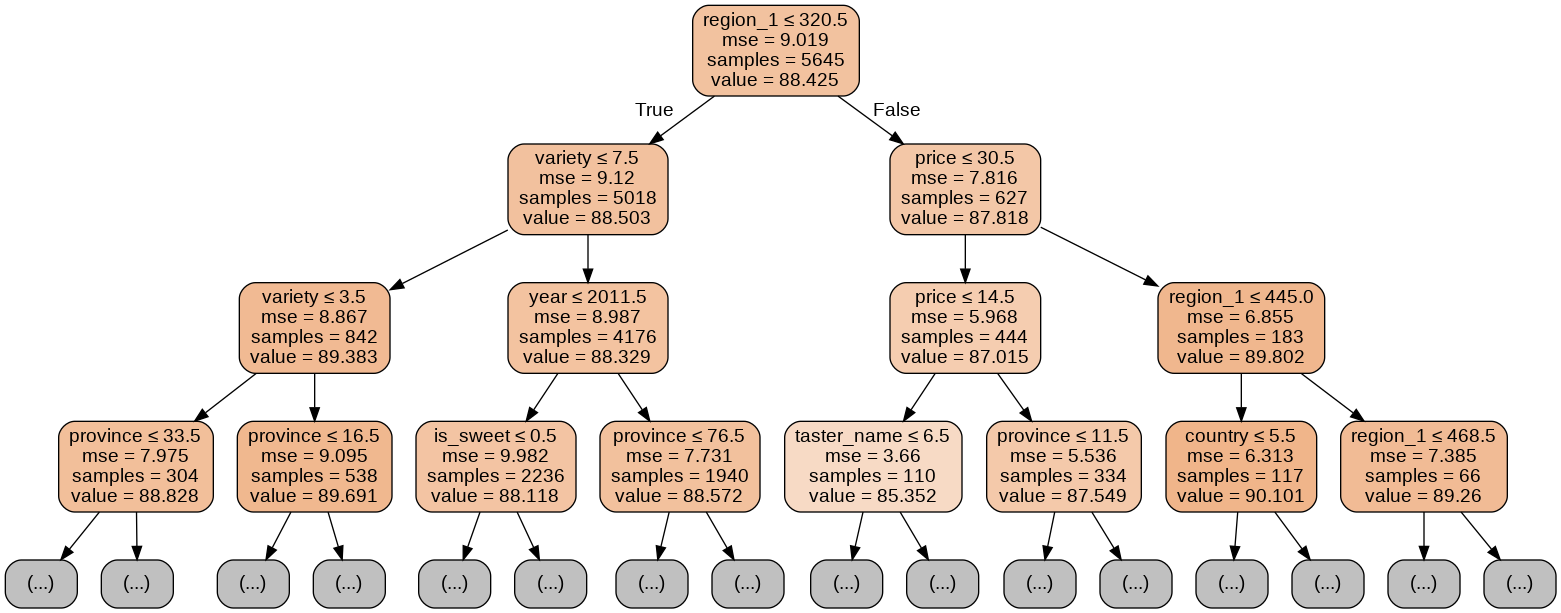

In [ ]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

A single DT of our RF model is helpful to understand how our model makes its predictions. Dispite this tree plot showing only the first 3 nodes, it conveys a great deal of information. This tree is also a good example of random selection of features and sample sizes in each node

For example, the root node first asks if the **region_1** is < than 320.5 and answers this question using a subset of the training dataset of size 5645. We can be easily realized that our initial MSE is similar to our baseline estimate of MSE. Value of the target is 88.425

The true child node asks if the **variety** is < than 7.5 and answers this question using a subset of the training dataset of size 5018. The MSE is almost the same as the previous node's MSE. Value of the target is 88.503

False child node asks if the **price** is < than 30.5 and answers this question using a subset of the training dataset of size 627. The MSE is improved in this node, as an indicator of more coherent node. Value of the target value of 87. 818

When a node's MSE does not improve further or when an internal node is left with minimum 2 samples (as we decided in the hyperparameter tuning part) the **DT** reaches its leaf nodes. Final predictions are generated by averaging the results of all **DTs**

## Evaluate Model on Test Data
We are going to generate our predictions by feeding our test_features into the RF model

In [ ]:
predictions = (random_forest_model.predict(X_test_array))

In [ ]:
%%time
mse_test = fit_evaluate_model(random_forest_model,
                              X_array,
                              y_array,
                              X_test_array,
                              y_test_array)

print('MSE of the test set is {}'.format(round(mse_test,2)))

MSE of the test set is 4.93
CPU times: user 1.83 s, sys: 24.6 ms, total: 1.86 s
Wall time: 1.86 s


Our evaluation from our test set using **RF** has significantly lowered the baseline estimate. MSE decreased from 9.01 to 4.93 showing 45% improvement

This serves as a proof that our **wineRatingPredictor** is a good predictor of points and can be a useful product for our online-wine-seller client

# 8. Interpret Model Predictions
### Actuals Vs. Predicted points

In [ ]:
def PlotPredictedVSActual(predictions, actuals):
    figsize(20, 10)
    plt.rcParams['font.size'] = 14

    # histogram of predictions
    ax = plt.subplot(121)
    ax.hist(predictions,
            bins=10, 
            color='#971539', 
            edgecolor='white')
    
    ax.set_xlabel('points', size=14)
    ax.set_xticks(range(80, 101))
    ax.set_ylabel('count', size=14)
    ax.set_title('Predicted Distribution', size=16)
    plt.grid(b=True, axis='y', alpha=0.3)

    # histogram of actual values
    ax2 = plt.subplot(122)
    ax2.hist(actuals,
             bins=20, 
             color='#971539', 
             edgecolor='white')
    
    ax2.set_xlabel('points', size=14)
    ax2.set_xticks(range(80, 101))
    ax2.set_ylabel('count', size=14)
    ax2.set_title('Actual Distribution', size=16)
    plt.grid(b=True, axis='y', alpha=0.3)

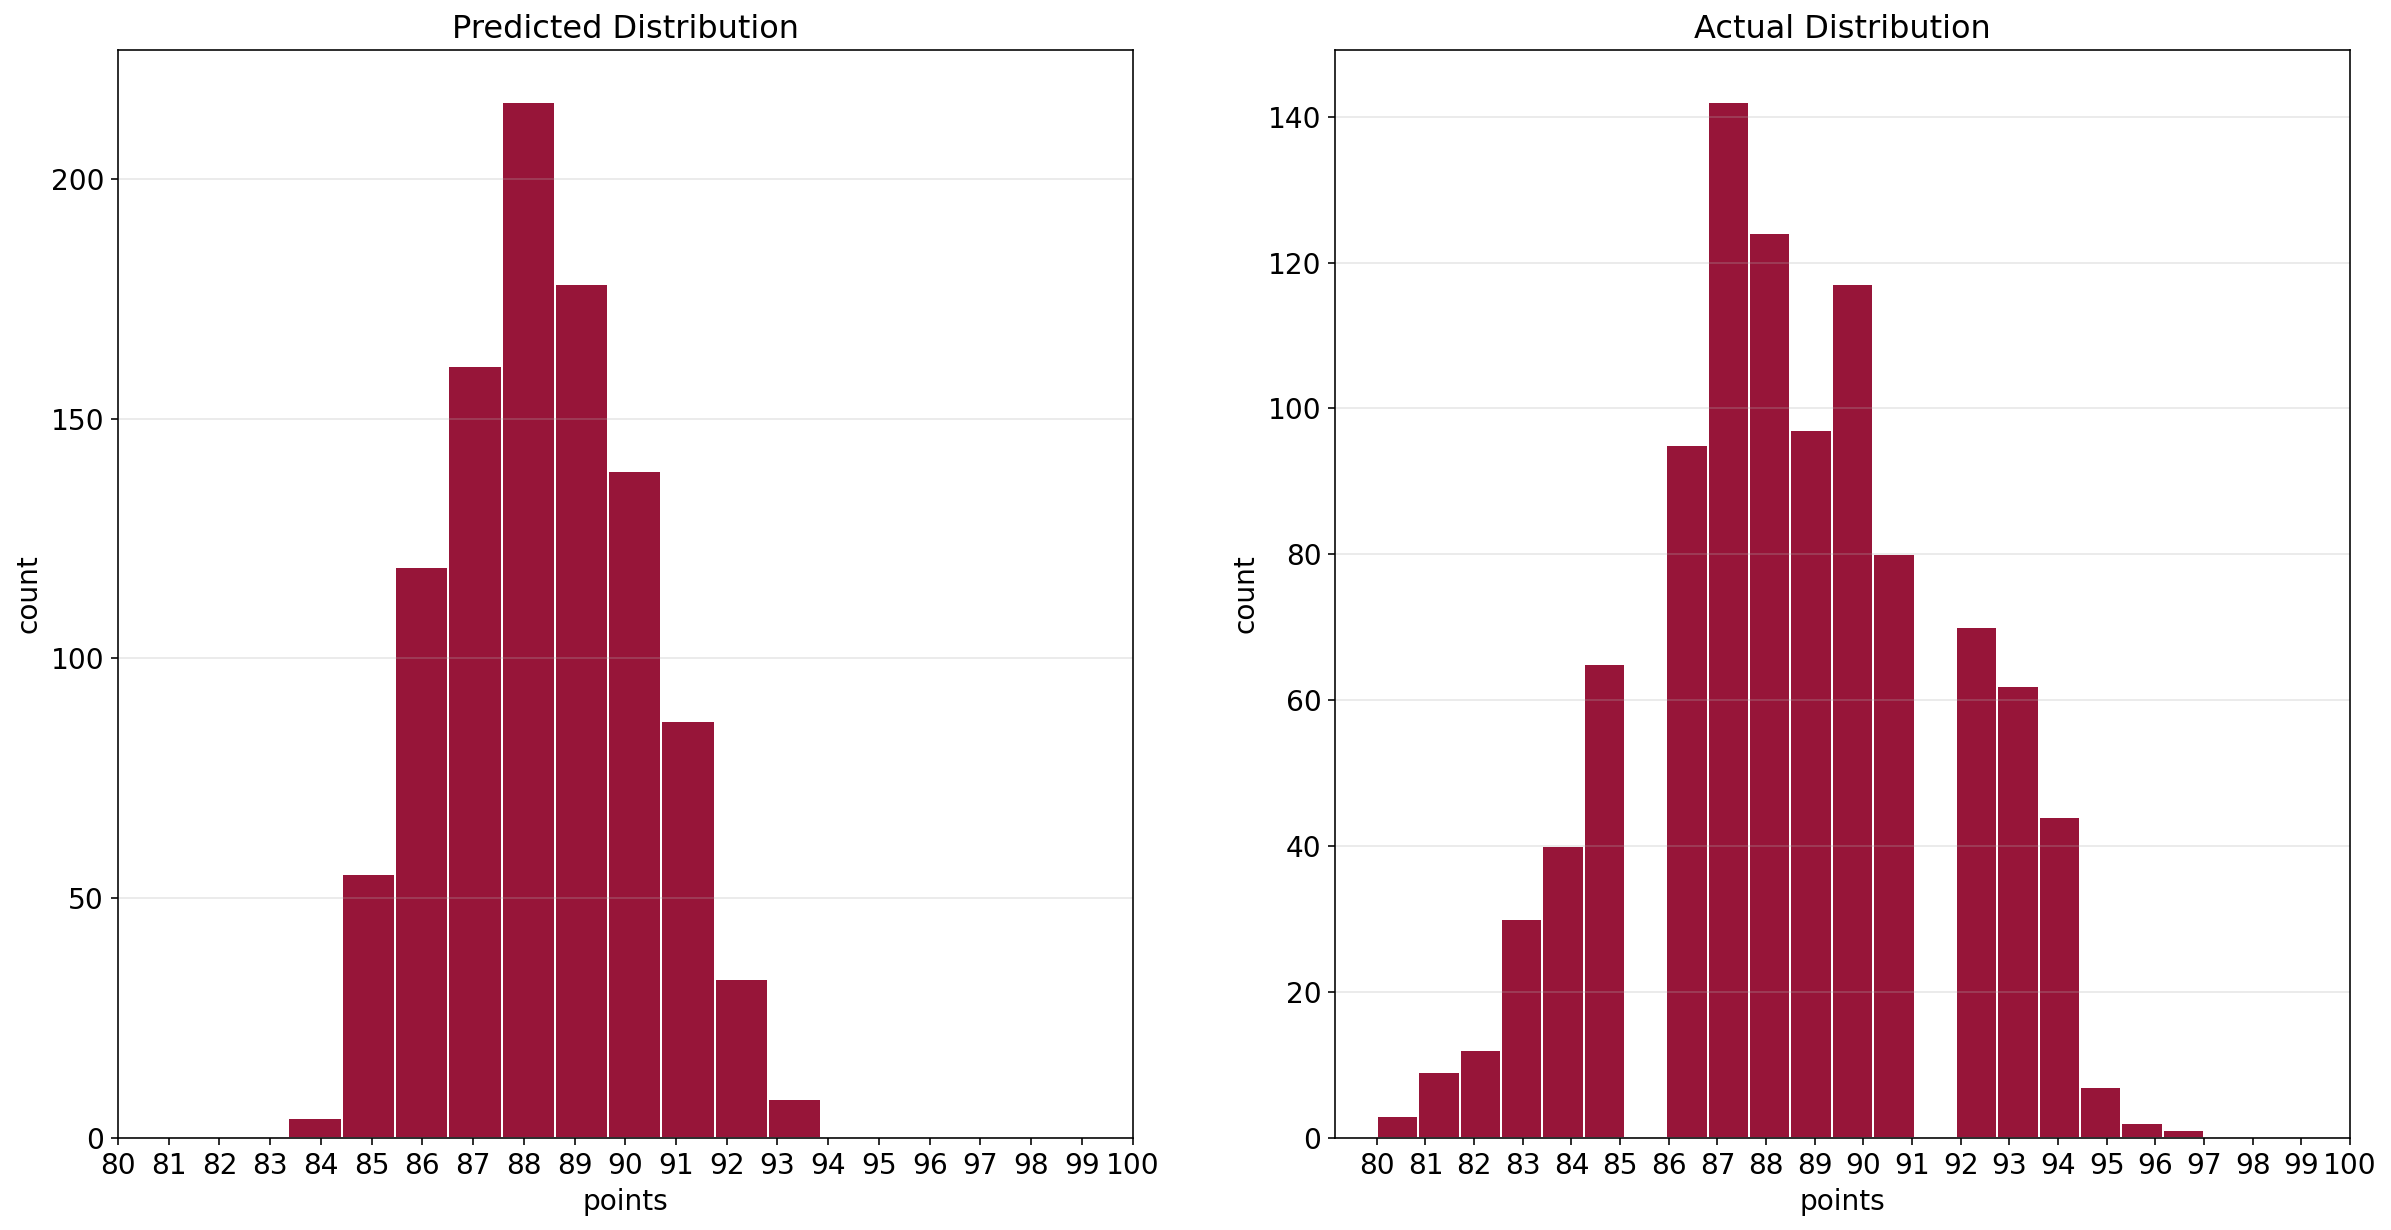

In [ ]:
PlotPredictedVSActual(predictions, y_test_array)

**Predicted Distribution** is wider than **Actual Distribution** 

**Our RF model was able to predict points within 83 and 94 points**. *It was not able to predict the outliers or less-frequent points*

+ points below 83
+ points above 94

This could be an area for improvement in our **wineRatingPredictor**, but I shall leave it up to you, *My Fellow Scientists*

We have already satisfied our project goal and its important to stay within the scope of our boundaries

# 8.1 Interpret Feature Importance

In [ ]:
def PlotFeatureImportances(model, feature_names):
    feature_importances = (pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_}))

    feature_importances = (feature_importances.sort_values(by='importance', ascending=False))
    figsize(20, 10)
    plt.rcParams['font.size'] = 14
    sns.set(font_scale=1.5, style='whitegrid')

    # color
    labels = np.array(feature_importances.feature)
    values = np.array(feature_importances.importance) 
    colors = ['#808080' if (y < max(values)) else '#971539' for y in values]

    # the plot
    ax = sns.barplot(x='importance', 
                     y='feature', 
                     data=feature_importances, 
                     palette=colors)

    # title and save plot
    plt.title('Feature Importances', size=16)
    
    # plt.savefig("FeatureImportances.png")

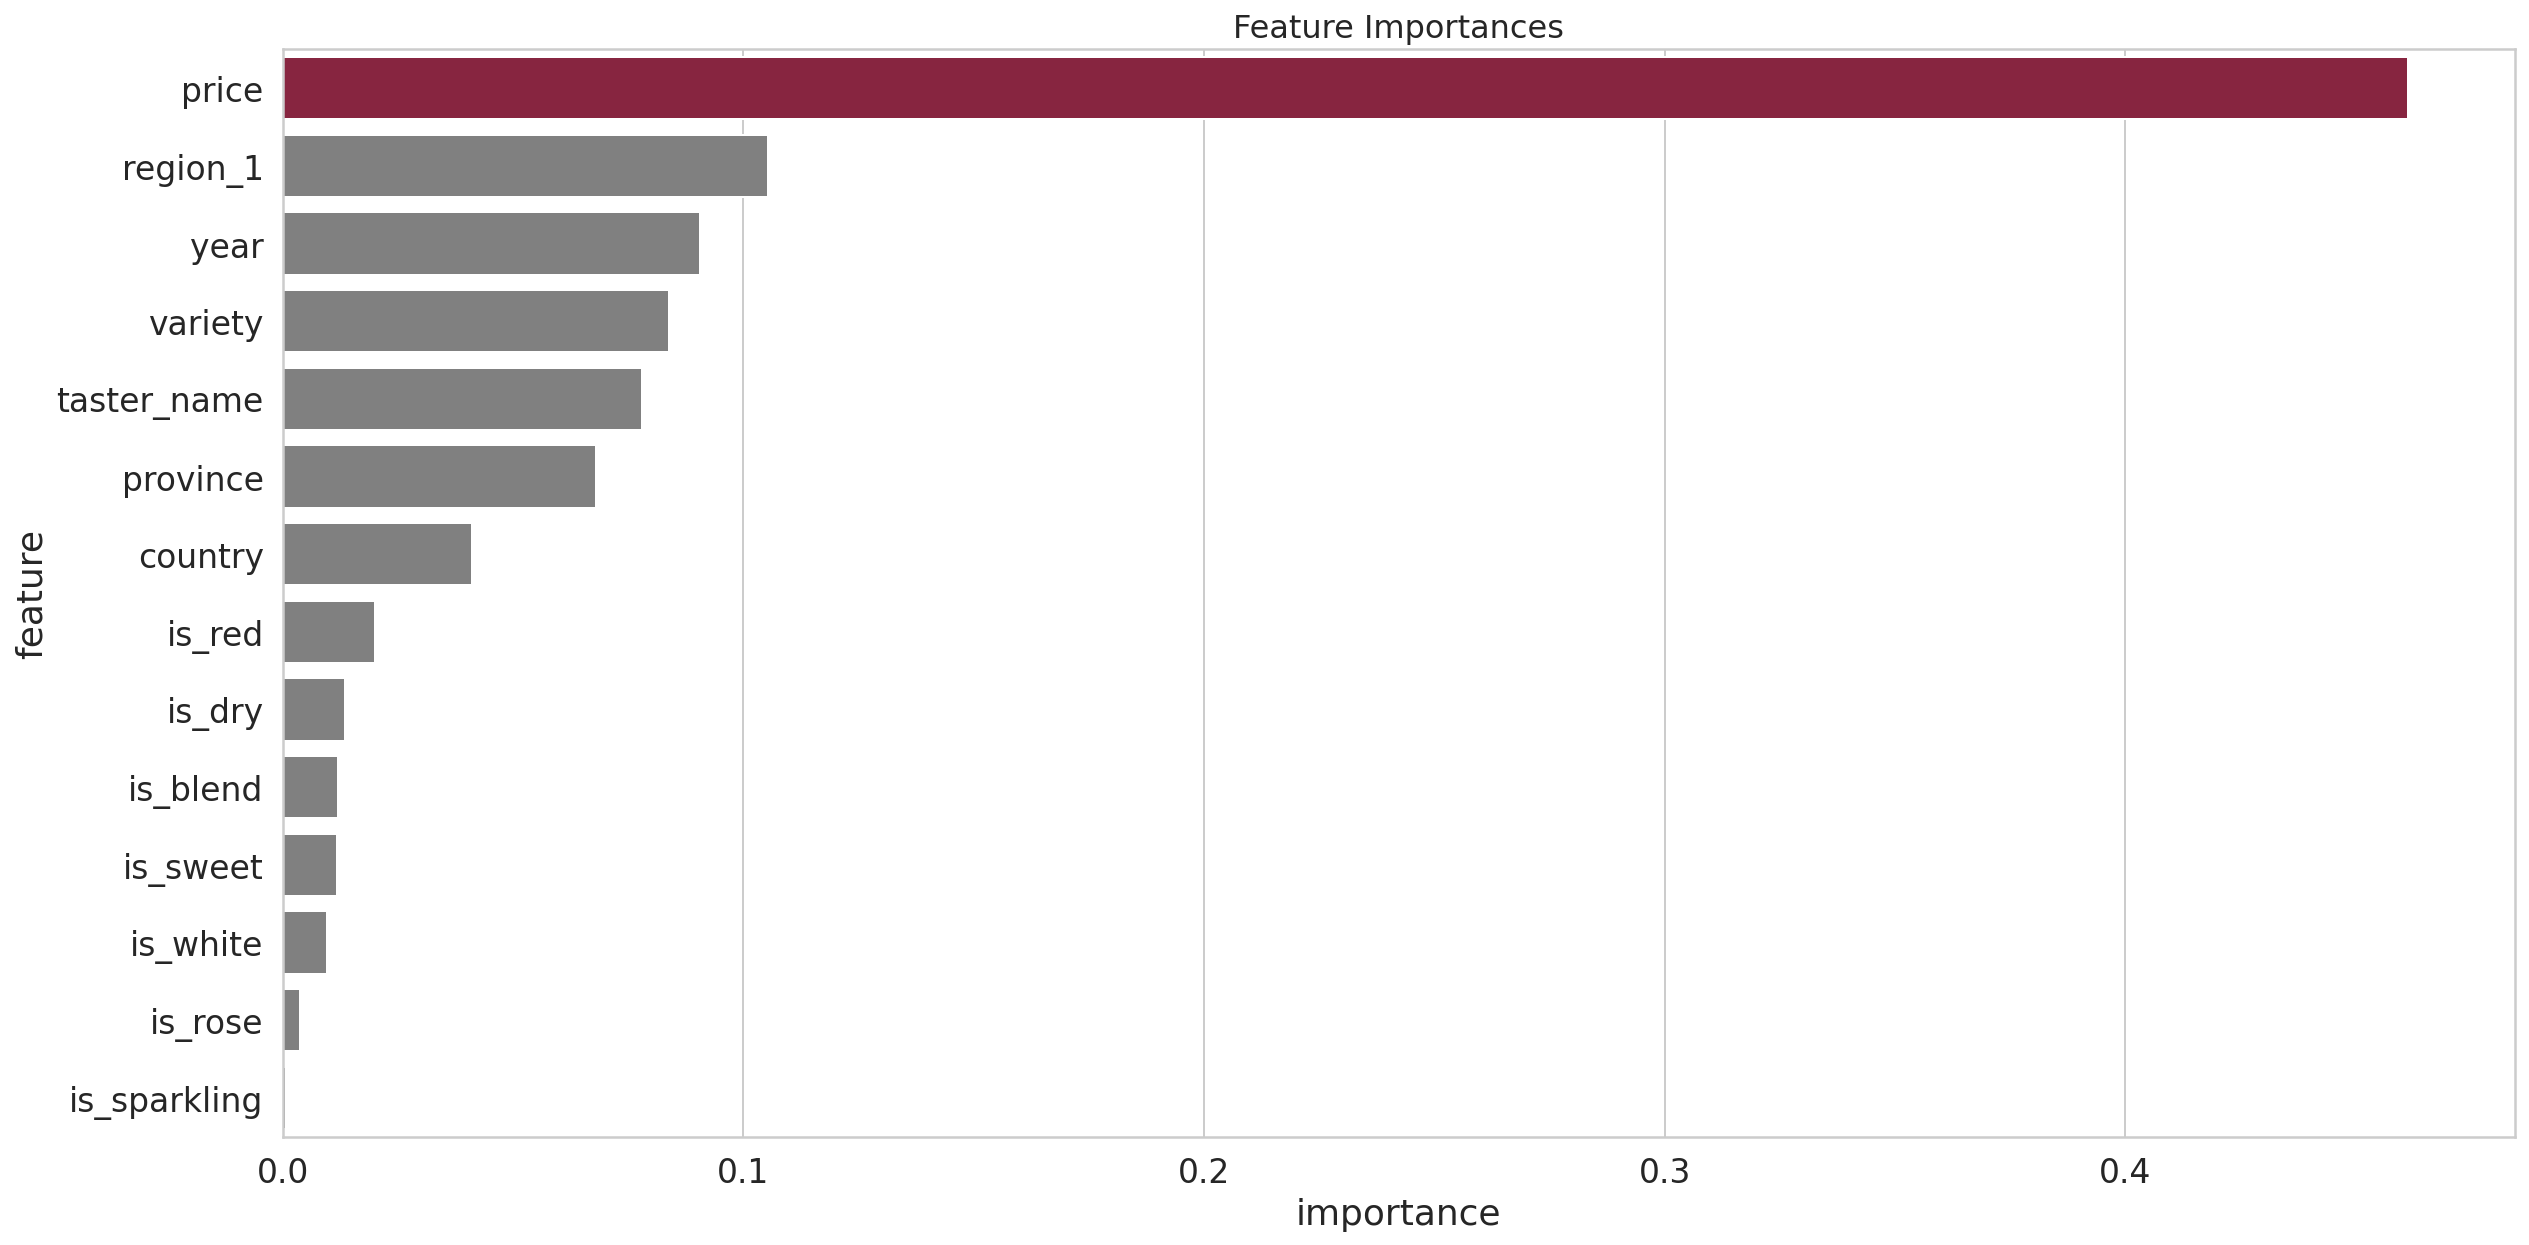

In [ ]:
PlotFeatureImportances(random_forest_model, test_features.columns)

In [ ]:
# extract feature importances into a df
feature_importances = (pd.DataFrame({'feature': test_features.columns, 'importance': random_forest_model.feature_importances_}))

feature_importances = (feature_importances.sort_values(by='importance', ascending=False))

feature_importances

Based on our **RF** model, the most importance features for predicting the wine are:

+ price 
+ region_1
+ year 
+ variety
+ taster_name

*These are inline with our preliminary study developed during EDA*

A comprehensive text-mining and sentiment analysis may help finding more valuable features from **description and variety** features. This can also help the model to predict higher and lower wine points

### Example from a wrong & correct predicton
We will try to explain the predictions that our model gets very wrong and an example the model gets correct. To observe that, we are going to look at the maximum of the residuals and minimum of the residuals and use **LIME** (Locally Interpretable Model-agnostic Explanations) library

# 8.2 Wrong Prediction

In [ ]:
# find the residuals
residuals = abs(predictions - y_test_array)

# exact the worst and best prediction
wrong = X_test_array[np.argmax(residuals), :]
right = X_test_array[np.argmin(residuals), :]

In [ ]:
# create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_array, 
                                                   mode='regression',
                                                   training_labels=y_array,
                                                   feature_names=test_features.columns)

Prediction: [90.33783208]
Actual Value: 82


Text(0.5, 0, 'Effect on Prediction')

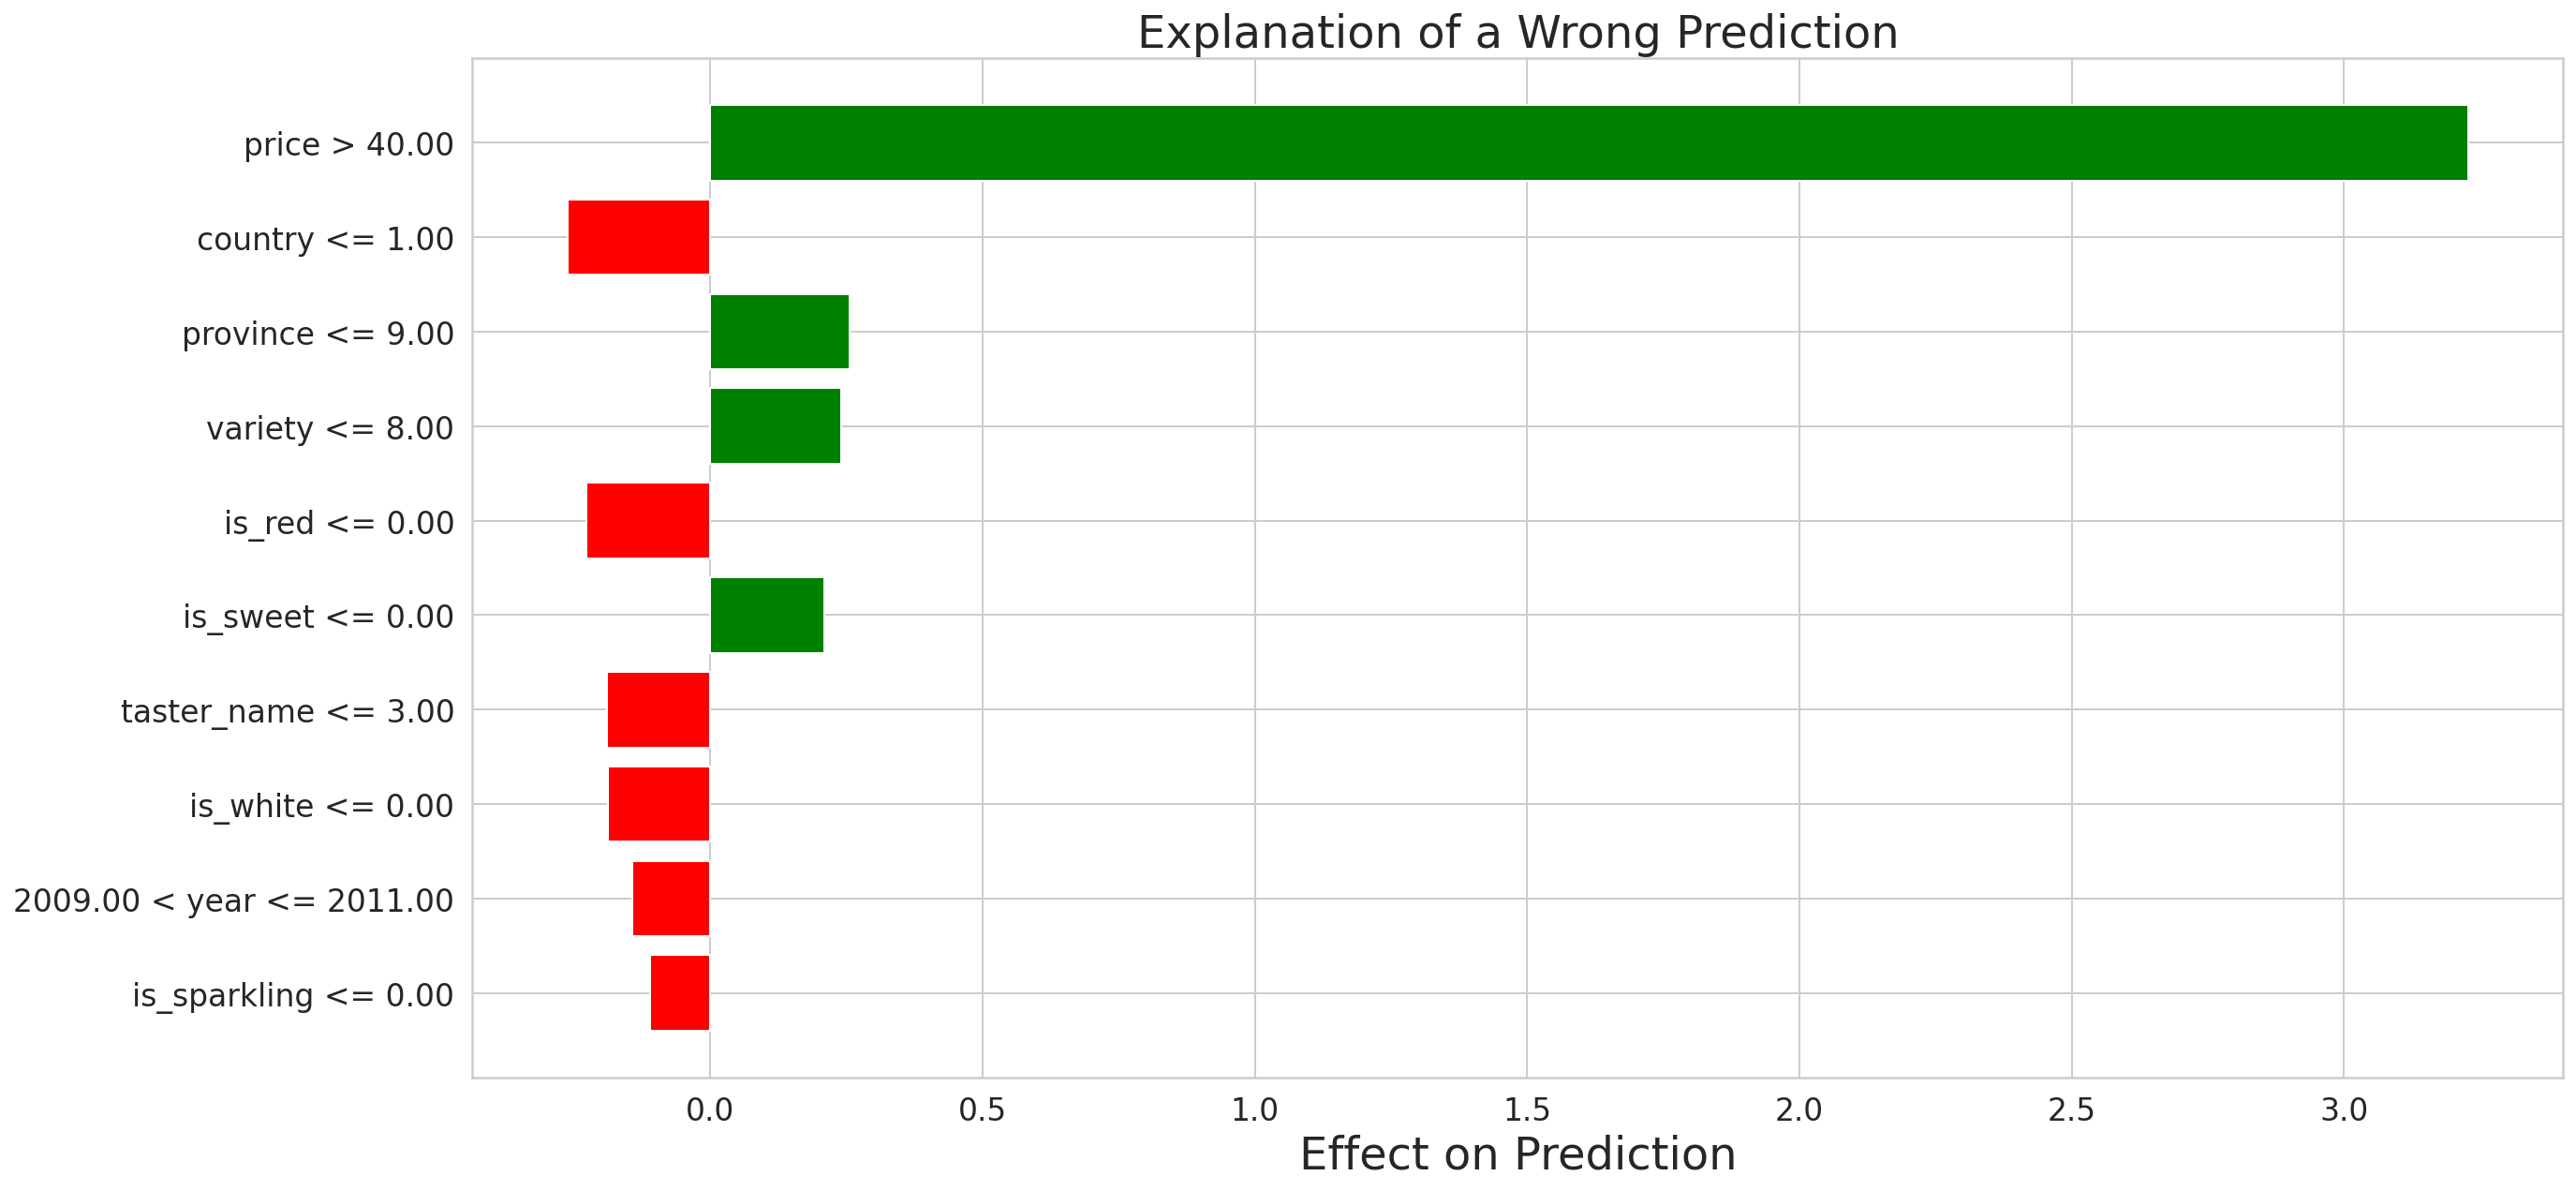

In [ ]:
# display the predicted and true value for the wrong instance
print('Prediction: {}'.format(random_forest_model.predict(wrong.reshape(1, -1))))
print('Actual Value: {}'.format(y_test_array[np.argmax(residuals)]))

# explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row=wrong, predict_fn=random_forest_model.predict)

# plot the prediction explaination
figsize(20, 10)
plt.rcParams['font.size'] = 24
wrong_exp.as_pyplot_figure()
plt.title('Explanation of a Wrong Prediction', size=24)
plt.xlabel('Effect on Prediction', size=24)

In this example, our **RF model** predicted a score of **90** when it is actually **82**

The plot from LIME shows us the contribution to the prediction from each of the features. For example, positive contributions are colored in green and negative contributions are colored in red

We notice that the **price** significantly increased the prediction because it was above 40. **Country and is_red** decreased the prediction slightly since is_red value was 0 and country was 1 which is the value for us

# 8.3 Right Prediction

Prediction: [87.00346181]
Actual Value: 87


Text(0.5, 0, 'Effect on Prediction')

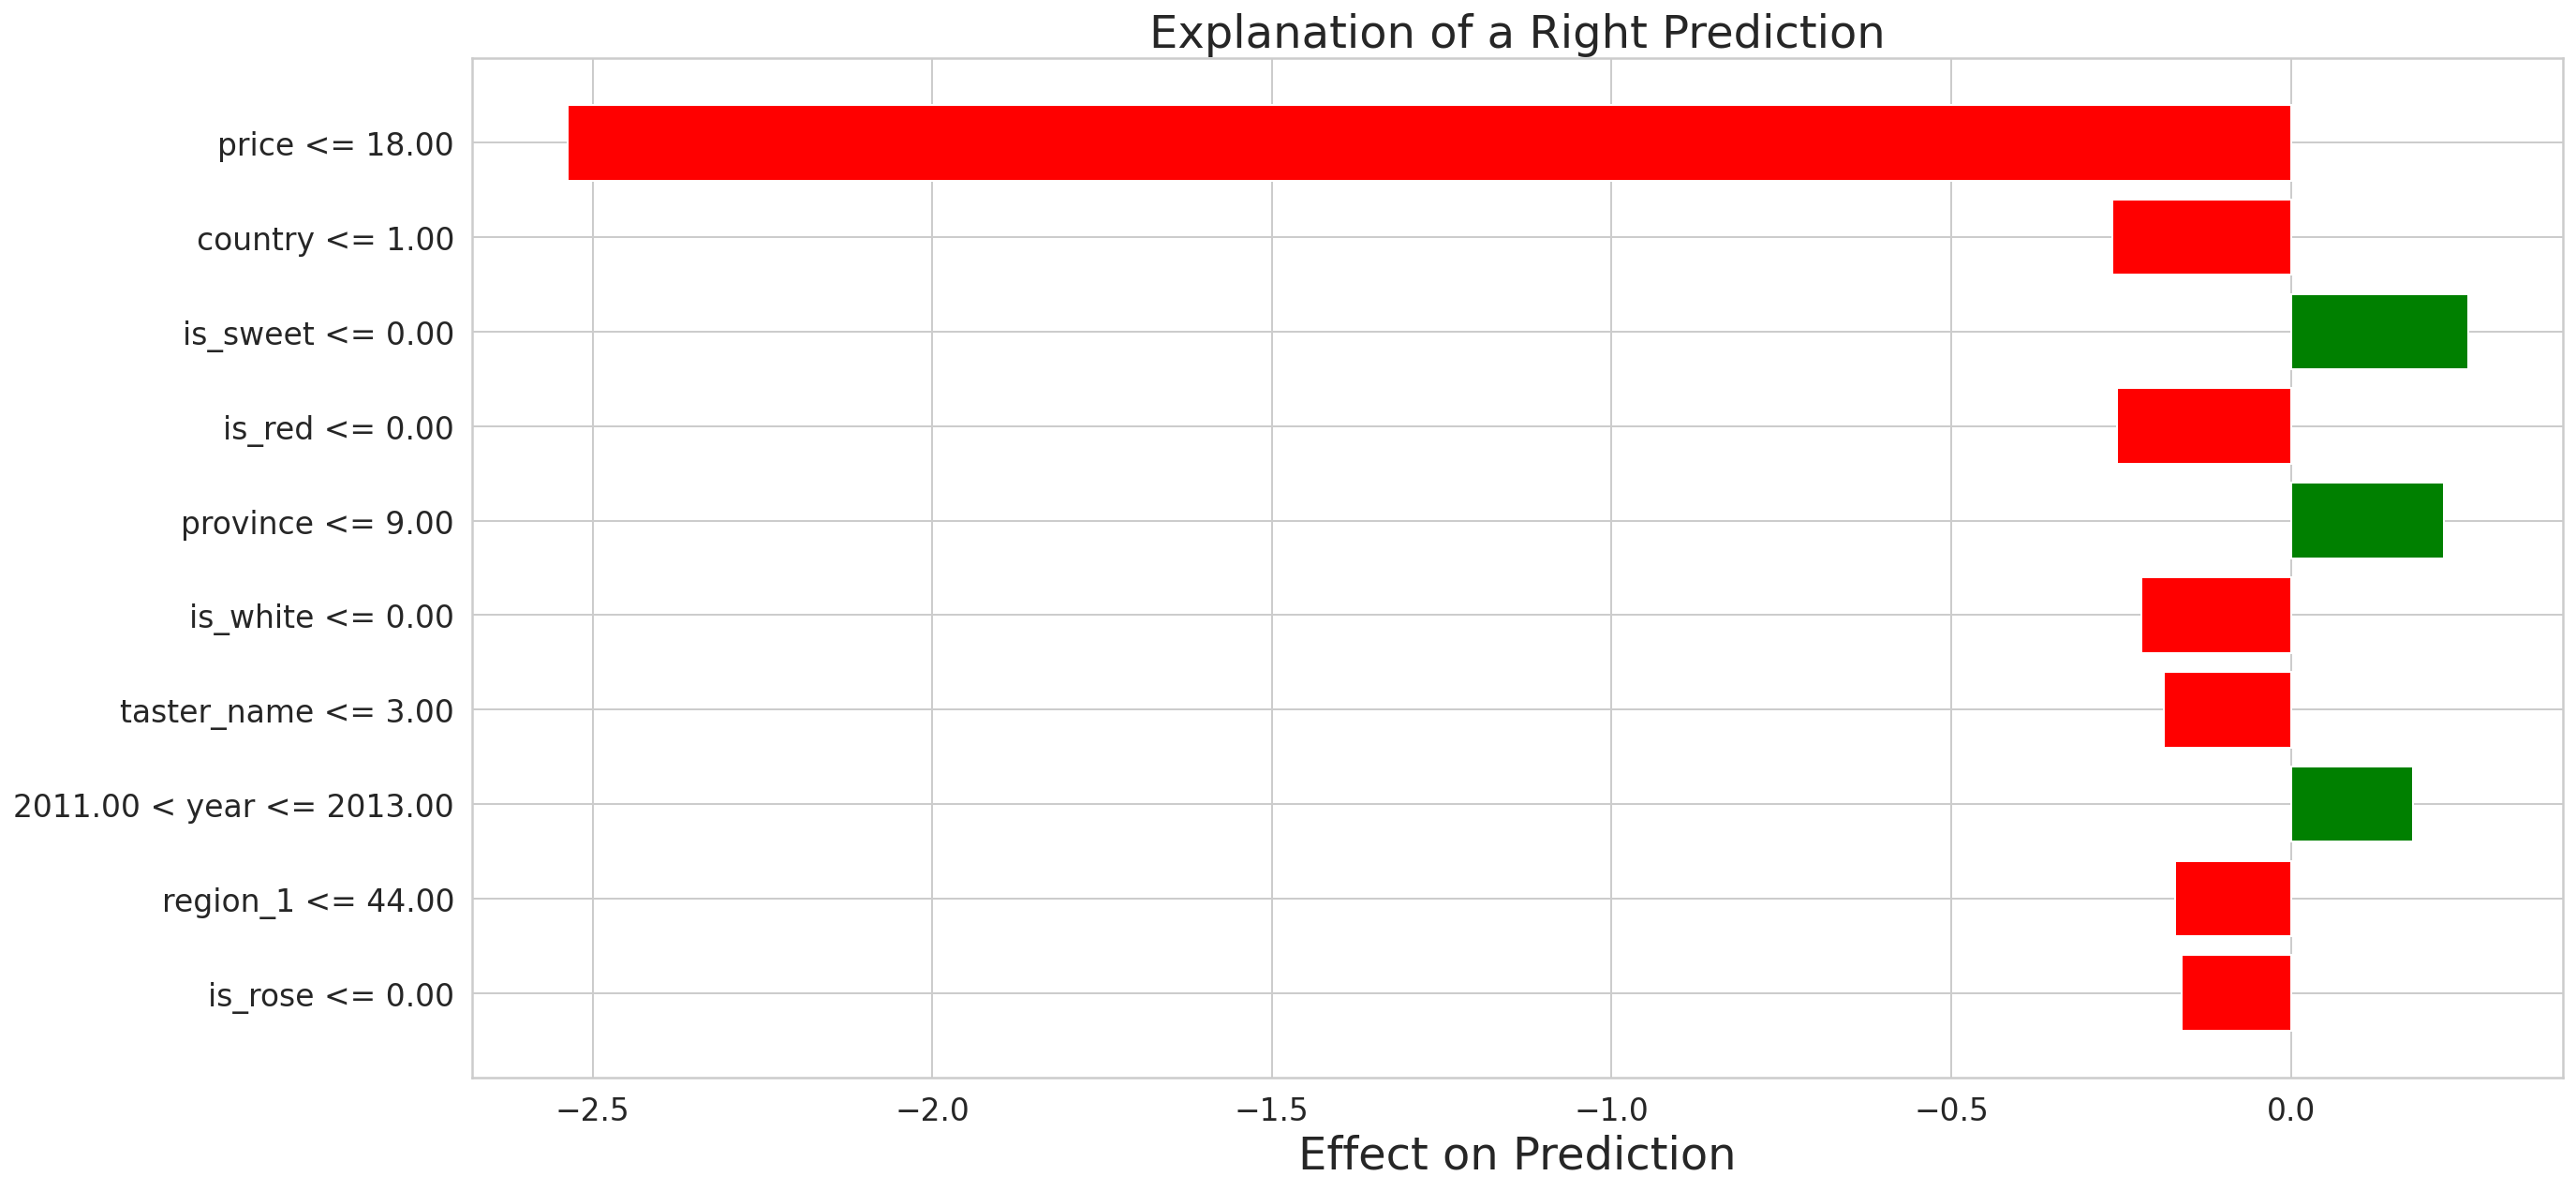

In [ ]:
# display the predicted and true value for the wrong instance
print('Prediction: {}'.format(random_forest_model.predict(right.reshape(1, -1))))
print('Actual Value: {}'.format(y_test_array[np.argmin(residuals)]))

# explanation for wrong prediction
right_exp = explainer.explain_instance(data_row=right, predict_fn=random_forest_model.predict)

# plot the prediction explaination
figsize(20, 10)
plt.rcParams['font.size'] = 24
right_exp.as_pyplot_figure()
plt.title('Explanation of a Right Prediction', size=24)
plt.xlabel('Effect on Prediction', size=24)

A **price** lower than 18, decreased the predictions, so has other features except **province**. Another valuable observation is that this is the prediction that our model got right, even in that case there is 0.003 difference between the actual and the predicted wine points

# 9. Draw Conclusions
I set out to answer the question: **Can I build a good wineRatingPredictor using ML to predict wine points from a set of features

Given the result from my 3rd notebooks, the answer is an overwhelming YES!

The 2 most important findings from this analysis:

**Firstly, using a given dataset and its set of features, I created a RF model to infer the wine points with a reasonable variance of 4.9. My model significantly lowered (45%) the baseline, serving as evidence to my initial question**

**Secondly, using features: *price, region, production year, variety of the grapes, taster name, province, country, color of the wine (red, white, rose) taste of the wine (dry, sweet, sparkling), blend of a wine*. The most useful predictors turned out to be **price, region_1, year, variety of the grapes and a taster name**

# 9.1 Additional Areas for Improvement:

Extending prediction range: so that less-frequent target values can be predicted by the model. The current sample dataset is dominated by wines from the most dominant countries (US, Italy, France, Spain), feeding more data from non-present countries might help the model to learn better the determiners of the less-frequent points

Using NLP to extract stronger predictors: currently, the strongest predictor is “price”. Extracting more features from the description related to wine taste and notes can help create strong predictors like price, decreasing prediction error of the model

![](https://drive.google.com/uc?export=view&id=1vu0AnrqIi-OK_3u8kd0BNCgCmtLfZ5iw)